<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Practice_captioning/blob/branch_%EB%B0%B1%EC%9A%B4%EC%B2%A0/coco_custom30k_2304181800_vgg_T_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

# 윤성(230417 주석)
# import nltk
# nltk.download("stopwords")
# from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model

In [3]:
from google.colab import auth
auth.authenticate_user()

### 드라이브 마운트 & os확인

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
#  gs://coco_custom30k/custom30k.zip

In [7]:
from zipfile import ZipFile

In [8]:
# !wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip # 전체롤드

In [9]:
! gsutil cp gs://coco_custom30k/custom30k.zip /content/coco_custom30k

Copying gs://coco_custom30k/custom30k.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][  4.6 GiB/  4.6 GiB]   80.2 MiB/s                                   
Operation completed over 1 objects/4.6 GiB.                                      


In [10]:
with ZipFile("/content/coco_custom30k") as zfile:
  zfile.extractall(".")

In [11]:
import os
sample_path ="/content/content/custom_train_coco_30k"
sample_train = os.listdir(sample_path)

# print(sample_train[:3])

In [12]:
print(len(sample_train), sample_train[:3])

30000 ['000000541771.jpg', '000000037124.jpg', '000000446815.jpg']


In [13]:
# with GFile("gs://coco_custom30k/custom30k.zipl", "rb") as f:
#     dataset = pickle.load(f)

# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [14]:
# import pandas as pd
# import json
# # i = 0
# # with open(f'/content/drive/MyDrive/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
# #윤성(230412)
# with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인
# # with open(f'/content/drive/Shareddrives/coco_dataset/annotations/captions_train2017.json', 'r') as f: # 마운트 확인


#     data = json.load(f)
#     data = data['annotations']

# img_cap_pairs = []

# for sample in data:
#     img_name = '%012d.jpg' % sample['image_id']
#     img_cap_pairs.append([img_name, sample['caption'],sample['image_id']])

# captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption','image_id'])
# captions['image'] = captions['image'].apply(
#     lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
# )
# captions = captions.reset_index(drop=True)
# print(captions.head(3))



In [17]:
# # 캡션 내역 확인
# df_captions_in_COCO.head()
# print(df_captions_in_COCO.shape)

# print(
# df_captions_in_COCO.iloc[0,0],
# "\n",
# df_captions_in_COCO.iloc[0,1],
# "\n",
# df_captions_in_COCO.iloc[0,2])

In [18]:
# # df to dict


# mypath_dict = {row['image']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

# # Or, use the 'image_id' column as the key
# myid_dict = {row['image_id']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

In [19]:
# print(len(mypath_dict), len(myid_dict))

In [20]:
# print(myid_dict[9])
# # print(mypath_dict)

In [21]:


# my_sample_path = []
# my_image_id= []

# for jpg_file in sample_train:
#     my_sample_path.append(sample_path+"/" +jpg_file)


#     # exctract id in sample
#     image_id = int(jpg_file.split('.')[0])
#     my_image_id.append(image_id)

# print(my_sample_path[:2],"\n", len(my_sample_path))
# print()
# print(my_image_id[:3], len(my_image_id))



In [22]:
# # Function to check if the image ID is in the my_image_id list
# def keep_id(image_id):
#     return image_id in my_image_id

# # Create a custom dictionary with only the partial image IDs
# my_custom_train_set = {k: v for k, v in myid_dict.items() if keep_id(k)}

captions (json 으로 만든), id는 11만개
폴더에 실제로 지금 가져온 id는 3만개
위 코드를 통해서 아이디를 위에 caption 
즉 내 폴더에있는 아이디만 가지고 dict 를 만듬

In [23]:
# updated_dict = {}
# for k, v in my_custom_train_set.items():
    
#     new_key = sample_path+"/{:012d}.jpg".format(k)
#     updated_dict[new_key] = v


In [24]:
# len(updated_dict)

#### Load some of the random images

In [25]:
# # 샘플 확인용

# imgIdss= list(updated_dict.keys())
# import random
# random.shuffle(imgIdss)


In [26]:
# print(imgIdss[9])

In [27]:
# import matplotlib.pyplot as plt
# import skimage.io as io

# # 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
# fig = plt.gcf()
# fig.set_size_inches(16, 16)

# next_pix = imgIdss
# random.shuffle(next_pix)

# for i, img_path in enumerate(next_pix[0:12]):
    
#     sp = plt.subplot(4, 4, i + 1)
#     sp.axis('Off')
#     I = io.imread(img_path)
#     plt.imshow(I)
#     print( updated_dict[img_path][0])

# plt.show()

In [28]:
import pickle
import tensorflow as tf
from tensorflow.io.gfile import GFile
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
with open("/content/drive/MyDrive/3조/test2_pickle", "rb") as f:    
    df = pickle.load(f)

In [30]:
print(df.columns)


# updated_dict = dataframe.set_index("Img_address").iloc[:,2:-1].to_dict()
updated_dict={}

for i in range(len(df)):
  img_address = df.iloc[i]['Img_address']
  caption_list = [df.iloc[i]['caption_1'],df.iloc[i]['caption_2'],df.iloc[i]['caption_3'],df.iloc[i]['caption_4'],df.iloc[i]['caption_5']]

  updated_dict[img_address] =caption_list

Index(['id_key', 'Img_address', 'caption_1', 'caption_2', 'caption_3',
       'caption_4', 'caption_5', 'caption_list'],
      dtype='object')


In [31]:
dataset =updated_dict

print(len(dataset))
print(list(dataset.items())[0])
# list(image_features.keys())[0]

# dataset 에 <start>, <end> 넣기, LSTM 용


newdataset = {k: ['<start> '   +cap+ ' <end>' for cap in caps] for k,caps in dataset.items()}

print(len(newdataset))
print(list(newdataset.items())[0])
print(len(list(newdataset.values())[0]))

dataset =newdataset


28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.'])
28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['<start> A giraffe eating food from the top of the tree. <end>', '<start> A giraffe standing up nearby a tree  <end>', '<start> A giraffe mother with its baby in the forest. <end>', '<start> Two giraffes standing in a tree filled area. <end>', '<start> A giraffe standing next to a forest filled with trees. <end>'])
5


Preprocess and tokenize the captions

In [32]:
import itertools

# from sklearn.model_selection import train_test_split



keys = list(dataset.keys())

random.seed(7)
random.shuffle(keys)
# 임시 : sample은 개수
train_size= int(len(dataset)*0.9)

val_size = len(dataset)-train_size
print(train_size, val_size)


train_keys =keys [:train_size]
val_keys = keys[train_size:]

data_train = {k : dataset[k] for k in train_keys}
data_val = {k : dataset[k] for k in val_keys}



25961 2885


In [33]:
list(data_train.items())[:2]

[('/content/content/custom_train_coco_30k/000000230903.jpg',
  ['<start> A yellow and red train traveling down tracks. <end>',
   '<start> A silver, red, and yellow train approaching on the tracks.  <end>',
   '<start> A yellow and red train is at a train stop.  <end>',
   '<start> Front diagonal view of commuter train on tracks, outside between platforms. <end>',
   '<start> A train sits stationary on a track adjacent to a house.  <end>']),
 ('/content/content/custom_train_coco_30k/000000535100.jpg',
  ['<start> A lady sits by an airport window as an aircraft is closely parked. <end>',
   '<start> The woman smiles while sitting in an airport. <end>',
   '<start> a woman stands in front of a window <end>',
   '<start> a photo of a person sitting near a window with an air plane outside <end>',
   '<start> A woman sitting next to a window smiles for a picture. <end>'])]

Preprocess and tokenize the captions

In [34]:
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer

# 30K 단어 토큰화 # 15k만들기는 아직 보류

def tokenize_mycaption(dataset, max_words=15000):
  
  flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

  tokenizer = Tokenizer( oov_token='<oov>',num_words =max_words) # For those words which are not found in word_index
  tokenizer.fit_on_texts(flatten_list)
  total_vocab_words = len(tokenizer.word_index) 
  print("Vocabulary length: ", total_vocab_words)
  print(list(tokenizer.word_index.keys())[:10])
  return tokenizer, total_vocab_words

tokenizer, total_vocab_words = tokenize_mycaption(newdataset, max_words=9000)


Vocabulary length:  15215
['<oov>', 'a', 'end', 'start', 'on', 'of', 'the', 'in', 'with', 'and']


In [35]:
total_words = 9000

In [36]:
# max_index = 0
# for seq in tokenizer.texts_to_sequences(dataset):
#   max_index =max(max_index, max(seq))
# total_words = max_index+1
# print(total_words)

In [37]:
# # 해당 3만개 데이터에 대한 tokenizer 저장  (15691 단어 수)

# import pickle

# # Save the configuration and weights to a file
# with open(f"my_tokenizer_{my_part}.pkl", "wb") as f:
#     pickle.dump({"tokenizer": tokenizer}, f)

In [38]:
dataset_list = list(dataset)


sample_link = dataset_list[0]


sample_captions = dataset[sample_link]


sample_link, sample_captions

('/content/content/custom_train_coco_30k/000000000025.jpg',
 ['<start> A giraffe eating food from the top of the tree. <end>',
  '<start> A giraffe standing up nearby a tree  <end>',
  '<start> A giraffe mother with its baby in the forest. <end>',
  '<start> Two giraffes standing in a tree filled area. <end>',
  '<start> A giraffe standing next to a forest filled with trees. <end>'])

In [39]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    # zca_whitening=False,
    # zca_epsilon=1e-06,
    # rotation_range=0,
    width_shift_range=0.1, # changed
    height_shift_range=0.1, # changed
    # brightness_range=None,
    shear_range=0.1, # changed
    zoom_range=0.1, # changed
    # channel_shift_range=0.0,
    # fill_mode='nearest',
    # cval=0.0,
    horizontal_flip=True, # changed
    vertical_flip=False,
    # rescale=None,
    # preprocessing_function=None,
    # data_format=None,
    # validation_split=0.0,
    # interpolation_order=1,
    # dtype=None
)

In [40]:
# Encoder 인 Xception 모델 호출, image_feature, imsize, error_imgs 선언, img_preprocess (이미지 사이즈 model 에 맞게 + resize, + 정규화 + feature 추출)


from tensorflow.keras.applications.xception import Xception
from tqdm.notebook import tqdm
import cv2
import numpy as np

model = Xception(include_top=False, pooling='avg',  weights='imagenet')

# model.compile()

image_features = {}

imsize = (299,299)
# dataset.keys()
error_imgs = []
# 윤성(230411/aug : True->False)
def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =True  ):
# def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =False  ):
    for img in tqdm(list(dataset.keys())):
        try:
            image = io.imread(img)
            if image.ndim != 3:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

            # Resize each image size 299 x 299 or 224 X 224
            image = cv2.resize(image, (imsize[1], imsize[0]))
            image = np.expand_dims(image, axis=0)
            if aug == True:
              augmented_image = data_gen.flow(image, batch_size=1).next()
              image = augmented_image

            # Normalize image pixels
            image = image / 127.5
            image = image - 1.0

            # Extract features from image
            feature = model.predict(image)
            
            [img] = feature

        except:
            print(f"Failed to process image {img}")
            error_imgs.append[img]

83683744/83683744 [==============================] - 0s 0us/step


In [41]:
# 윤성(230411 주석처리)
# MobileNet Feature extraction 용
from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)

modified_mobilenetv3small = Model(inputs=mobilenet.input, outputs=x)

# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_mobilenetv3small)


4334752/4334752 [==============================] - 0s 0us/step


In [42]:




# t_image = cv2.resize(im2, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

# t_image.shape

# t_image = np.expand_dims(t_image, axis=0)

# t_image.shape

#   # Normalize image pixels
# t_image = t_image / 127.5
# t_image = t_image - 1.0
# print(modified_mobilenetv3small.predict(t_image).shape)
# modified_mobilenetv3small.predict(t_image)[0][:10]


In [43]:
# 윤성추가(230411)
# model_incep.summary()
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [44]:
# from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

58889256/58889256 [==============================] - 1s 0us/step


In [45]:
#윤성추가(230411)
# modified_vgg16.summary()

# img_preprocess(dataset, imsize =IMAGE_SHAPE, model = modified_vgg16)
# 뒤에 각모델마다  호출할때 모델 피팅 따로적용해야함

In [46]:
# 윤성 07,08,09
import pickle
# Get the tokenizer's configuration and weights
# image_features

# 각자 Sampletrain 별로 저장하기 
# ex) train

# 윤성(230411/aug : True->False)
# with open(f"my_feature_{len(image_features)}_{my_part}.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_True.pkl", "wb") as f:
# with open(f"vgg16_feature_{len(image_features)}_aug_False.pkl", "wb") as f:
# with open("vgg16_feature_30000_aug_True.pkl", "wb") as f:  
#     pickle.dump({"feature": image_features}, f)

In [47]:
import pickle

extract =False 
# 모델바꾸기 , # modelchange
# model_e = 'vgg_f' # false for aug
model_e = 'vgg_t' # false for aug
# model_e = 'mobilenet_f' # false for aug
#  윤성(23041711 변경)
# model_e = 'xception_t' # false for aug
# model_e = 'xception_f' # f for aug

# model_e = 'mobilenet_t' # false for aug

if extract == True:
  pass
# img_preprocess(dataset)
else:
  # feature 파일 로드, (dict 형태)

  # with open("/content/drive/MyDrive/3조/vgg pkl/vgg16_feature_10000_01.pkl", "rb") as f:  
# 윤성(230411 경로수정)


  if model_e=='vgg_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_True.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
# 윤성(230417 추가)
  elif model_e=='vgg_f':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_False.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)

  elif model_e=='xception_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_yes_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='xception_f':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_no_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)

  elif model_e=='mobilenet_t':
      print("loading :",model_e)
      with open("/content/drive/MyDrive/3조/features_Mobilenet_30K/my_feature_30000_mb_yes_aug.pkl", "rb") as f:    
        load_feature_file = pickle.load(f)

  elif model_e=='mobilenet_f':
        print("loading :",model_e)
        with open("/content/drive/MyDrive/3조/features_Mobilenet_30K/my_feature_30000_mb_no_aug.pkl", "rb") as f:    
          load_feature_file = pickle.load(f)
  else:
    raise 
      
  

  load_features = list(load_feature_file.values())[0]
  print(len(load_features))

  # print(type(load_features))
  keys = list(load_features.keys())
  values =list(load_features.values())


  load_feature_dict  = {}
  print(load_feature_dict)
  my_filepath_key =[sample_path+"/"+ key[-16:] for key in keys]
  print("my_filepath_key:", my_filepath_key[0])
  for i in range(len(keys)):
      load_feature_dict[my_filepath_key[i]] = values[i]


  print("load_feature_dict:",len(load_feature_dict))

  first_item_key = list(load_feature_dict.keys())[0]
  first_item_value = list(load_feature_dict.values())[0]


  # io.imread(first_item_key)


  # 다시 키를 내경로에 맞게 수정하는 과정 필요



  print(first_item_value.shape)
  print( keys[0])

loading : vgg_t
30000
{}
my_filepath_key: /content/content/custom_train_coco_30k/000000000025.jpg
load_feature_dict: 30000
(1, 512)
/content/content/custom_train_coco_30k/000000000025.jpg


In [48]:
len(load_feature_dict)

30000

In [49]:
# testsample_dict

# img_preprocess ( dataset = testsample_dict )


In [51]:
# # 이미지 읽어보기 [0]

# print(first_item_key[-16:])

# print(my_filepath_key[:5])
# print(len(my_filepath_key[0]))

# # index [0:9999]
# im = io.imread(my_filepath_key[23])

# plt.imshow(im)
# plt.show()
# '/content/content/custom_train_coco_30k/000000000544.jpg'
# '/content/content/custom_train_coco_30k/000000000025.jpg'

In [52]:
dataset[my_filepath_key[12]]

['<start> Two people standing in a kitchen looking around.  <end>',
 '<start> A couple of men are standing in a kitchen <end>',
 '<start> Two people looking at a large kitchen  <end>',
 '<start> An elderly man and woman looking around in a kitchen. <end>',
 '<start> Two people standing close to each other while standing in a kitchen. <end>']

In [53]:
if load_feature_dict:
  image_features = load_feature_dict


print("Image features length: ", len(image_features))

Image features length:  30000


In [54]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length_f(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length_f(dataset)
print(max_length)
max_length_v = max_length_f(data_val)
print(max_length_v)

max_length_t = max_length_f(data_train)
print(max_length_t)


max_length

26
25
26


26

Make a Data Generator
We have to train our model on 6221 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6221 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

For example:¶
The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

Capture.PNG

In [55]:
#create input-output sequence pairs from the image description.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
        #  description 인 경우 10,000개 
            feature = features[key][0]
            # print("features",type(features), len(features), list(features.keys())[0]) #  features 자체는 image_features dict
            # print("feature",type(feature), len(feature))
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    num=0
    # walk through each description for the image
    for desc in desc_list: # desc_list 는 caption의 list를 뜻함
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # print(len(seq))
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # print("in_seq",in_seq)
            
            # encode output sequence
            # out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            out_seq = to_categorical([out_seq], num_classes=total_words+1)[0] # start, end token 추가 +1

            # print("out_seq",out_seq, "\n", len(out_seq))
            
            # store
            # append num
            num+=1
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
    # print("append 한 횟수 :",num)

    return np.array(X1), np.array(X2), np.array(y)

In [56]:
# create_sequences(tokenizer, max_length, data_train, image_features)

gen = data_generator(data_val, image_features, tokenizer, max_length)

# for i, a in enumerate(gen):
#   print(i)
#   if i >2:
#    break;


# print(list(image_features.items())[0])
# print(list(data_train.items())[0])




In [57]:
model_e[:-2]

'vgg'

In [58]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention

# define the captioning model
def define_model(total_words, max_length, model= model_e[:-2]):
    # features from the CNN model squeezed from 2048 to 256 nodes

    if model == "xception":
        inputs1 = Input(shape=(2048,)) #for Xception (1,2048)
    elif model == "vgg":
        inputs1 = Input(shape=(512,))# for VGG 512
    elif model == "mobilenet":
        inputs1 = Input(shape=(576,)) #for Xception (1,2048)
    
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax',name = "output")(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam') # metrics = ['acc']

    # summarize model
    print(model.summary())

    # 윤성(23041415 주석)
    # plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [59]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
        
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            'W1': self.W1,
            'W2': self.W2,
            'V': self.V,
        })
        return config

embedding_dim = 256
units = 256
vocab_size = total_words + 1  # Add 1 for zero padding

# 윤성(230417)
# encoder_input = Input(shape=(576,))
encoder_input = Input(shape=(512,))
# encoder_input = Input(shape=(2048,))

fe1 = Dense(embedding_dim, activation='relu')(encoder_input)
fe2 = Dropout(0.5)(fe1)

decoder_input = Input(shape=(max_length,))
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_input)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.2, name='decoder_lstm')
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=[fe2, fe2])

# Add custom attribute 'decoder_units' to the decoder_lstm layer
decoder_lstm.decoder_units = units

attention_layer = BahdanauAttention(units)
context_vector, attention_weights = attention_layer(fe1, state_h)
decoder_concat = Concatenate(axis=-1)([context_vector, state_h])

dense_layer = Dense(units, activation='relu')
dense_output = dense_layer(decoder_concat)
output = Dense(vocab_size, activation='softmax')(dense_output)

att_model = Model([encoder_input, decoder_input], output)

In [61]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.6 MB/s eta 0:00:00


In [69]:
from transformers import TFBertMainLayer, BertConfig

class CustomBert(TFBertMainLayer):
    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)

    def call(self, inputs, **kwargs):
        return super().call(inputs=inputs, inputs_embeds=inputs[0], **kwargs)



/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: The `inputs` argument is deprecated and will be removed in a future version, use `input_ids` instead.
  return py_builtins.overload_of(f)(*args)


In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, Embedding
from tensorflow.keras.models import Model
from transformers import TFBertModel, BertConfig, TFBertMainLayer
# from transformers import TFBertForConditionalGeneration


# Assuming image_features has shape (batch_size, 512)
encoder_input = Input(shape=(512,))
transformer_hidden_size = 768
n_positions = 26  # The number of positions you want to consider

# Add a dense layer to match the hidden size of the transformer
cnn_features = Dense(transformer_hidden_size, activation='relu')(encoder_input)

# Add position embedding
position_embedding = np.zeros((n_positions, transformer_hidden_size))
position_embedding_layer = tf.keras.layers.Embedding(
    n_positions, transformer_hidden_size, trainable=False, weights=[position_embedding]
)
position_encoding = position_embedding_layer(tf.range(0, n_positions)[tf.newaxis, :])

# Add token type embedding
token_type_embedding_layer = tf.keras.layers.Embedding(2, transformer_hidden_size)
token_type_encoding = token_type_embedding_layer(tf.zeros((1, n_positions), dtype=tf.int32))

# Combine embeddings and image features
input_with_embeddings = cnn_features[:, tf.newaxis, :] + position_encoding + token_type_encoding

# Pass the input through the transformer encoder
bert_config = BertConfig.from_pretrained('bert-base-uncased')
transformer_encoder = CustomBert(bert_config)
encoded_features = transformer_encoder([input_with_embeddings]).last_hidden_state

# Decoder
max_length = 26
vocab_size = 9000  # Set this to the actual size of your vocabulary



In [93]:
from tensorflow.keras.layers import Input, Dense, Add, LayerNormalization, Embedding
from tensorflow.keras.models import Model
from transformers import TFBertModel, BertConfig, TFBertMainLayer

# ...

class CustomTFBertMainLayer(TFBertMainLayer):
    def call(self,
             inputs_embeds=None,
             attention_mask=None,
             token_type_ids=None,
             position_ids=None,
             head_mask=None,
             encoder_hidden_states=None,
             encoder_attention_mask=None,
             past_key_values=None,
             use_cache=None,
             output_attentions=None,
             output_hidden_states=None,
             return_dict=None,
             training=False,
             **kwargs):
        # Remove input_ids from the call arguments since we will use inputs_embeds
        return super().call(
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training,
            **kwargs
        )

# Decoder
max_length = 26
vocab_size = 9000  # Set this to the actual size of your vocabulary

decoder_input = Input(shape=(max_length,))
decoder_embedding = Embedding(vocab_size, transformer_hidden_size)(decoder_input)
decoder_position_embedding = position_embedding_layer(tf.range(0, max_length)[tf.newaxis, :])
decoder_input_with_embeddings = decoder_embedding + decoder_position_embedding

bert_config = BertConfig.from_pretrained('bert-base-uncased')
custom_bert_main_layer = CustomTFBertMainLayer(bert_config)

# Pass the input through the transformer decoder
decoded_output = custom_bert_main_layer(inputs_embeds=decoder_input_with_embeddings, encoder_hidden_states=encoded_features)

output = Dense(vocab_size, activation='softmax')(decoded_output.last_hidden_state)

# Create the model
transformer_model = Model([encoder_input, decoder_input], output)

# Print model summary
print(transformer_model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 768)          393984      ['input_25[0][0]']               
                                                                                                  
 tf.__operators__.getitem_15 (S  (None, 1, 768)      0           ['dense_25[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 input_30 (InputLayer)          [(None, 26)]         0           []                         

In [95]:
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',)
# Train the model using your dataset (e.g., COCO dataset)

In [98]:
transformer_model.summary()


# history_attention= train_our_model(model=transformer_model)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 768)          393984      ['input_25[0][0]']               
                                                                                                  
 tf.__operators__.getitem_15 (S  (None, 1, 768)      0           ['dense_25[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 input_30 (InputLayer)          [(None, 26)]         0           []                         

ValueError: ignored

In [ ]:
# train our model
# import os

# try:
#   os.mkdir("models")
# except:
#   print("models folder already exists")

# # testsample_dict
# print(max_length)
# # 윤성(230417)
# att_model = define_model(total_words+1, max_length)
# caption_model = define_model(total_words+1, max_length)


In [ ]:
# att_model.summary()

Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_42 (Dense)               (None, 256)          131328      ['input_17[0][0]']               
                                                                                                  
 input_18 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 26, 256)      2304256     ['input_18[0][0]']               
                                                                                           

In [97]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss', patience =3, verbose = 1)

In [96]:
from datetime import datetime
current_time = datetime.now()
timestamp = int(current_time.timestamp())
# print(timestamp)

fit_num=0




# model_save_name  =f"/content/drive/MyDrive/3조/Models/vgg16_{timestamp}+FN+{str(fit_num)}_caption_model.h5"
model_save_name  =f"/content/drive/MyDrive/3조/Models/{model_e}_{timestamp}+FN+{str(fit_num)}_caption_model.h5"

# print(model_save_name)
# caption_model.save("test_model.h5")
# caption_model.save(model_save_name)



BATCH_SIZE = 32


def train_our_model(data_train= data_train,
                    data_val=data_val,batch =BATCH_SIZE,
                    # model =caption_model):
                    model =att_model):  
  global fit_num

  index = model_save_name.find("FN") + 3
  fit_num = int(model_save_name[index])  

  fit_num+=1

  steps_per_epoch_train = train_size //BATCH_SIZE
  steps_per_epoch_val = val_size // BATCH_SIZE

  print('Dataset: ', len(dataset))
  print('Descriptions: val=', len(data_val))
  print('Descriptions: train=', len(data_train))
  print('Photos: =', len(image_features))
  print('Token Vocabulary Size:', total_words)
  print('Total vocabulary:', total_vocab_words)

  print('Description Length: ', max_length)

  
  fit_set = 1
  EPOCHS=60
  # EPOCHS=1
  # steps = len(dataset)

  # making a directory models to save our models

  # yield  []
  for i in range(fit_set):

    # train, val generator 
      train_generator = data_generator(data_train, image_features,tokenizer, max_length_t)
      val_generator = data_generator(data_val, image_features, tokenizer, max_length_v)
      # fit with generators with callbacks
      test_fit =model.fit(train_generator,  steps_per_epoch= steps_per_epoch_train,
                          validation_data =val_generator, validation_steps= steps_per_epoch_val,
                          callbacks=[early_stopping],epochs=EPOCHS,)
    # model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1, batch_size=BATCH_SIZE, validation_set = validation_loss = )      

      # 윤성(230412 비활성화)
      # model.save("models/model_" + str(i) +str(fit_num)+ ".h5")   
      model.save(model_save_name)
  return test_fit


In [ ]:
# print(model_save_name)
# caption_model.save(model_save_name)

In [ ]:
att_model.summary()
history_attention= train_our_model(model=att_model)

Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 256)          131328      ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 26, 256)      2304256     ['input_14[0][0]']               
                                                                                           

In [ ]:
# 윤성(230418 치환)
# caption_model = att_model
# loaded_model = caption_model
# CNN_model = loaded_model

fit 실행(epochs)

In [ ]:
# history = train_our_model(model = caption_model)

Dataset:  28846
Descriptions: val= 2885
Descriptions: train= 25961
Photos: = 30000
Token Vocabulary Size: 9000
Total vocabulary: 15215
Description Length:  26
Epoch 1/60
811/811 [==============================] - 62s 71ms/step - loss: 5.0965 - val_loss: 4.5835
Epoch 2/60
811/811 [==============================] - 51s 62ms/step - loss: 4.2609 - val_loss: 4.0720
Epoch 3/60
811/811 [==============================] - 51s 63ms/step - loss: 4.0181 - val_loss: 3.8650
Epoch 4/60
811/811 [==============================] - 50s 62ms/step - loss: 3.8297 - val_loss: 3.7900
Epoch 5/60
811/811 [==============================] - 51s 63ms/step - loss: 3.7446 - val_loss: 3.6825
Epoch 6/60
811/811 [==============================] - 51s 63ms/step - loss: 3.6567 - val_loss: 3.6474
Epoch 7/60
811/811 [==============================] - 51s 63ms/step - loss: 3.5926 - val_loss: 3.5926
Epoch 8/60
811/811 [==============================] - 51s 62ms/step - loss: 3.5532 - val_loss: 3.5279
Epoch 9/60
811/811 [=====

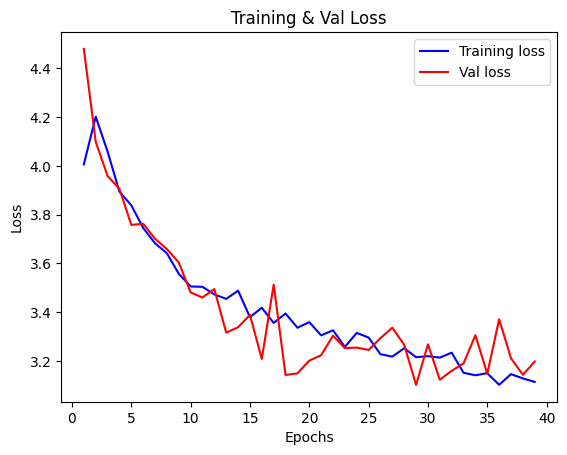

In [ ]:
import matplotlib.pyplot as plt

# Get the training loss history
# train_loss = caption_model.history['loss']
# print(caption_model.history.history.keys())
# 윤성(잠시막아둠)
# print(history.history.keys())

train_loss = history_attention.history['loss']
val_loss = history_attention.history['val_loss']


# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.title('Training & Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {
    'BahdanauAttention': BahdanauAttention,
}

In [ ]:
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16.h5")
# 윤성(230411)
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/model_01_vgg16_30k_aug(false).h5")
# 윤성 파일명 변경

# loaded_model = tf.keras.saving.load_model("models/model_01.h5")
for i,model_path in enumerate (os.listdir("/content/drive/MyDrive/3조/Models/")) :
  # print(i,model_path)  
  # if f"FN+{str (i)}" in model_path :
  # 윤성(23041711)
  if f"FN" in model_path and model_e[:-2] in model_path:  
  # if f"FN" in model_path and "xception" in model_path:    
    print(model_path)  
# 윤성(230417 vgg반영)    
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/vgg_f_1681718356+FN+0_caption_model.h5")
# loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/"+model_path)
# loaded_model_mobt = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/"+"mobilenet_t_1681371160+FN+0_caption_model.h5")

# print(loaded_model)
# loaded_model.summary()

vgg16_1681281673+FN+0_caption_model.h5
vgg16_1681345761+FN+0_caption_model.h5
vgg16_1681346139+FN+0_caption_model.h5
vgg16_1681347037+FN+0_caption_model.h5
vgg16_1681348012+FN+0_caption_model.h5
vgg16_1681349000+FN+0_caption_model.h5
vgg16_1681349922+FN+0_caption_model.h5
vgg16_1681351290+FN+0_caption_model.h5
vgg16_1681352051+FN+0_caption_model.h5
vgg16_1681362950+FN+0_caption_model.h5
vgg_t_1681452398+FN+0_caption_model.h5
vgg_t_1681454356+FN+0_caption_model.h5
vgg_f_1681692253+FN+0_caption_model.h5
vgg_f_1681718356+FN+0_caption_model.h5
vgg_f_1681765952+FN+0_caption_model.h5
vgg_f_1681778746+FN+0_caption_model.h5
vgg_t_1681789398+FN+0_caption_model.h5
vgg_t_1681790039+FN+0_caption_model.h5


In [ ]:
len("1681718356")
f"90{timestamp}"

'901681790039'

In [ ]:
# loaded_model = load_model('model_path.h5, custom_objects=custom_objects)
loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/3조/Models/"+model_path, custom_objects=custom_objects)
loaded_model.summary()


Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 256)          131328      ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 26)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 26, 256)      2304256     ['input_14[0][0]']               
                                                                                           

In [ ]:

# att_model.load_weights("/content/drive/MyDrive/3조/Models/"+model_path)# weights 만 불러올



In [ ]:
# 윤성(230418막음)
# loaded_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# train_our_model(dataset,model=loaded_model)

In [ ]:
import matplotlib.pyplot as plt

# List of models you want to visualize
models = [caption_model, loaded_model,loaded_model_mobt,att_model]  # Replace with your actual models
model_names = ['current', 'loaded_model','loaded_model_mobt',att_model]  # Replace with your actual model names

# Find the maximum number of layers across all models
max_layers = max([len(model.layers) for model in models])

# Create a single figure for all subplots
fig = plt.figure(figsize=(15, max_layers * 5))

# Iterate through the models
for model_idx, model in enumerate(models):
    model_name = model_names[model_idx]

    # Access the layers of the current model
    layers = model.layers

    # Iterate through the layers and visualize the weights
    for layer_idx, layer in enumerate(layers):
        layer_name = layer.name
        layer_weights = layer.get_weights()

        if len(layer_weights) > 0:
            # Get the weight matrix for the layer (ignoring biases)
            weight_matrix = layer_weights[0]

            # Create a subplot for the current layer and model
            ax = fig.add_subplot(max_layers, len(models), layer_idx * len(models) + model_idx + 1)

            # Plot a histogram of the weight distribution
            ax.hist(weight_matrix.flatten(), bins=50)
            ax.set_title(f'{model_name}: {layer_name}')
            ax.set_xlabel('Weight value')
            ax.set_ylabel('Frequency')

# Display all subplots
plt.tight_layout()
plt.show()

NameError: ignored

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    # im=Image.open(filename)
    # print(filename)
    # print(im)
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)

['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_tr

In [ ]:
print(model_e[:-2])
x= np.arange(1,577)

y = np.sin(x/10)*2
noise = y+ np.random.normal(0,0.1, size = (1,576))
print(y.shape)
print(noise.shape)




vgg
(576,)
(1, 576)


In [ ]:




def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")

        
        if model_e[:-2] == "vgg":
            image = image.resize((224,224))
            print("resizing")
        elif(model_e[:-2] == "mobilenet"):
            image = image.resize((224,224))
            print("resizing")          

        else:
            image = image.resize((299,299))


        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        # if image.shape[2] == 4: 
        #     image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        # feature 늘리기
        # feature = np.exp(feature) # a a a a a 만 출력
        # feature = feature + noise
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'


    # units = decoder_lstm.decoder_units
    # attention_layer  = model.layers[-5]


    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        # print(attention_weights)

        # initial_state = model.layers[2](model.layers[1](photo))
        # decoder_embedding = model.layers[3](sequence)

        # decoder_outputs, state_h , state_c =decoder_lstm(decoder_embedding, initial_state = [initial_state, initial_state])
        # c_v , at_wt = attention_layer(model.layers[1](photo), state_h)


        # get_output = K.function([att_model.input], [output_tensor])

        # output_data = 


        pred = np.argmax(pred)
        # print("DEBUGGING")
        word = word_for_id(pred, tokenizer)
        # print(pred,word)
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end' or word =='<end>':
            in_text = in_text[:-3]  +"<"+in_text [-3:] + ">"
            break
    return in_text




In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'

    units = decoder_lstm.decoder_units
    attention_layer  = model.layers[-4]
    attention_weights_list = []


    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # pred = model.predict([photo, sequence], verbose=0)

        initial_state = model.layers[2](model.layers[1](photo))
        # print("initial_state",initial_state.shape)
        decoder_embedding = model.layers[3](sequence)

        # Sum the decoder_embedding tensor along the one-hot encoding axis
        # print("decoder_embedding",decoder_embedding.shape)

        decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=[initial_state, initial_state])

        # print("decoder_outputs",decoder_outputs.shape,"state_h", state_h.shape, "state_c",state_c.shape)
        # print(model.layers[1](photo).shape)
        

        # dense_output = tf.expand_dims(model.layers[1](photo), 1)  # Add a new dimension
        
        c_v, at_wt = attention_layer(decoder_outputs, state_h)
        # print("c_v",c_v.shape)
        
        # print("at_wt",at_wt.shape)
        attention_weights_list.append(at_wt)

        pred = model.predict([photo, sequence], verbose=0)


        pred = np.argmax(pred, axis=-1)




        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word

        if word == 'end' or word == '<end>':
            in_text = in_text[:-3] + "<" + in_text[-3:] + ">"
            break
    attention_weights_array = np.squeeze(np.array(attention_weights_list))
    return in_text, attention_weights_array

In [ ]:


ii = 4


photo = extract_features(img_paths[ii], CNN_model)

img = Image.open(img_paths[ii])
dataset[img_paths[ii]]




resizing
1/1 [==============================] - 0s 28ms/step


['<start> A close-up of the pizza pie in a pizza box. <end>',
 '<start> A thin crust pepperoni pizza is in a box. <end>',
 '<start> A thin crust pizza sitting inside of a pizza box. <end>',
 '<start> a thin crust pepperoni pizza in a cardboard box <end>',
 '<start> A pepperoni pizza sitting out in an open pizza box. <end>']

In [ ]:
#     units = decoder_lstm.decoder_units
# print(units)
result =  generate_desc(loaded_model, tokenizer,photo, max_length)
result[1].shape

# import keras.backend as K

(10, 26)

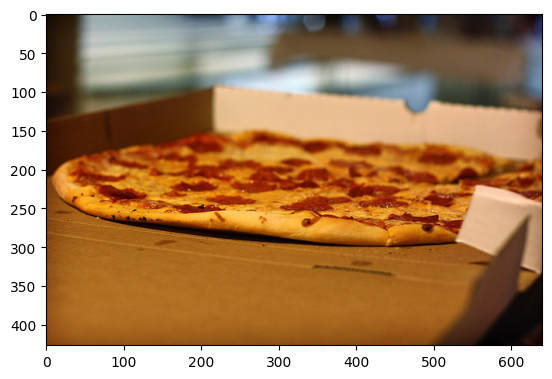

In [ ]:
result[1][3]
plt.imshow(img)


In [ ]:
result[0]

'<start> a plate of food with a pizza on it <end>'

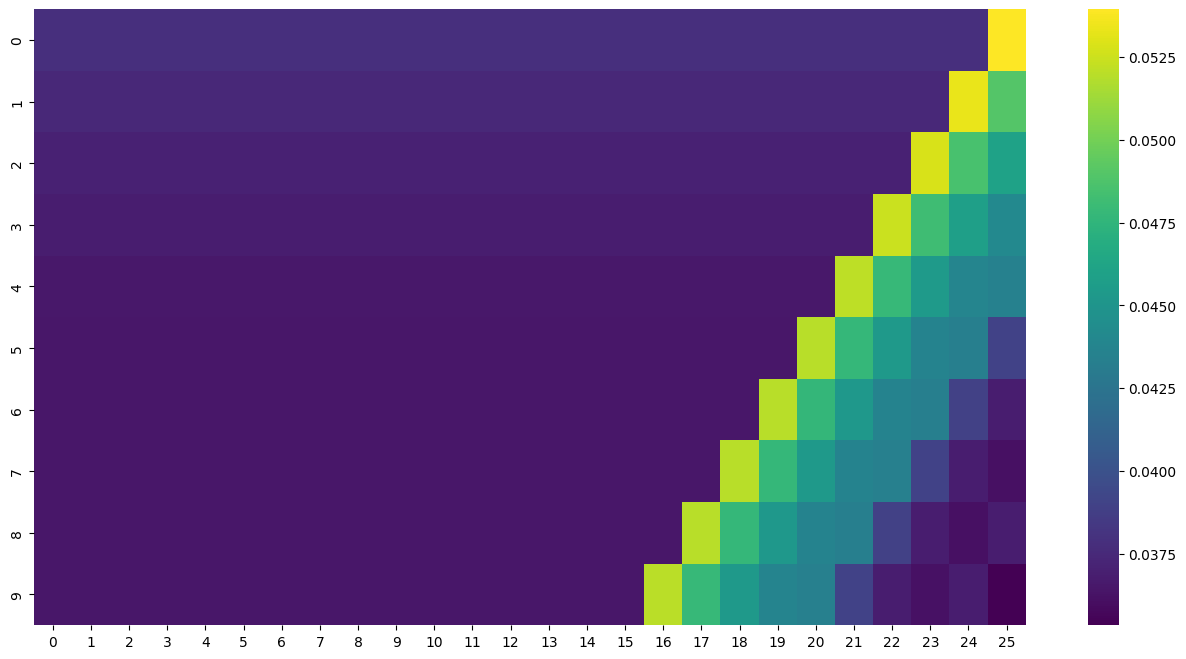

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
generated_text, attention_weights =generate_desc(loaded_model, tokenizer, photo, max_length)
plt.figure(figsize=(16,8))
# plt.figure(figsize=(10,8))
sns.heatmap(attention_weights, cmap ='viridis',)

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(image, attention_weights, caption, save_path=None):
    fig, axes = plt.subplots(nrows=len(caption), ncols=1, figsize=(10, len(caption) * 2))

    for idx, word in enumerate(caption):
        # Reshape attention weights to match the feature map dimensions
        attention_map = np.reshape(attention_weights[idx], (7, 7))

        # Normalize attention weights
        attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

        # Resize the attention map to the original image dimensions
        attention_map = cv2.resize(attention_map, (image.shape[1], image.shape[0]))

        # Overlay the attention map on the original image
        overlay = cv2.addWeighted(image, 0.6, np.expand_dims(attention_map, axis=-1) * 255, 0.4, 0)

        # Display the attention visualization
        axes[idx].imshow(overlay)
        axes[idx].set_title(word)
        axes[idx].axis('off')

    if save_path:
        plt.savefig(save_path)

    plt.show()

# Example usage


visualize_attention(img, result[1], result[0])


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# 윤성 (230412 앞에 있다)

IMAGE_SHAPE=(224, 224, 3)

# 윤성 (230417 주석 해제)
vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

In [ ]:
#  윤성(230417 최종 : model)
CNN_model= modified_vgg16
# CNN_model= modified
# xception_model = Xception(include_top=False, pooling="avg")
# CNN_model= Xception(include_top=False, pooling="avg")

# CNN_model= modified_mobilenetv3small
# caption_model.summary()
# CNN_model.summary()

# CNN_model= model

In [ ]:
# loaded_model.summary
# CNN_model.summary()
# model.shape

In [ ]:
print(caption_model, tokenizer, max_length)

NameError: ignored

In [ ]:
print(img_paths[2], CNN_model)

./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg <keras.engine.functional.Functional object at 0x7f28b007f430>


resizing
1/1 [==============================] - 0s 26ms/step



('<start> a group of sheep standing in a field <end>', array([[0.03832223, 0.03832223, 0.03832223, 0.03832223, 0.03832223,
        0.03832223, 0.03832223, 0.03832223, 0.03832223, 0.03832223,
        0.03832223, 0.03832223, 0.03832223, 0.03832223, 0.03832223,
        0.03832223, 0.03832223, 0.03832223, 0.03832223, 0.03832223,
        0.03832223, 0.03832223, 0.03832223, 0.03832223, 0.03832223,
        0.04194427],
       [0.03827379, 0.03827379, 0.03827379, 0.03827379, 0.03827379,
        0.03827379, 0.03827379, 0.03827379, 0.03827379, 0.03827379,
        0.03827379, 0.03827379, 0.03827379, 0.03827379, 0.03827379,
        0.03827379, 0.03827379, 0.03827379, 0.03827379, 0.03827379,
        0.03827379, 0.03827379, 0.03827379, 0.03827379, 0.04190056,
        0.03952845],
       [0.03818404, 0.03818404, 0.03818404, 0.03818404, 0.03818404,
        0.03818404, 0.03818404, 0.03818404, 0.03818404, 0.03818404,
        0.03818404, 0.0

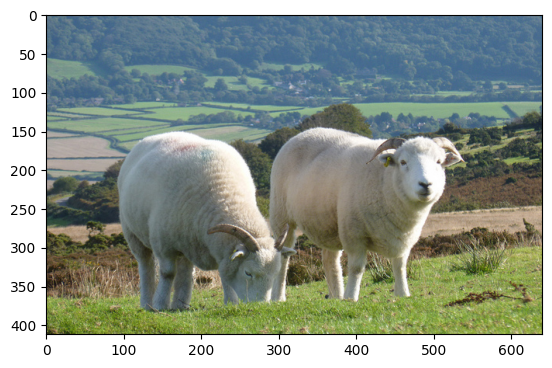

In [ ]:

# caption_model = loaded_model


ii = 2


photo = extract_features(img_paths[ii], CNN_model)

img = Image.open(img_paths[ii])
description = generate_desc(loaded_model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
# for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
#     # im=Image.open(filename)
#     # print(filename)
#     # print(im)
#     img_paths.append(filename)

#     if len(img_paths)>10:
#       break
val_key = list(data_val.keys())
random.shuffle(val_key)
for filename in val_key:
    img_paths.append(filename)

    if len(img_paths)>10:
      break


print(img_paths)

['/content/content/custom_train_coco_30k/000000398949.jpg', '/content/content/custom_train_coco_30k/000000261333.jpg', '/content/content/custom_train_coco_30k/000000030187.jpg', '/content/content/custom_train_coco_30k/000000452881.jpg', '/content/content/custom_train_coco_30k/000000460830.jpg', '/content/content/custom_train_coco_30k/000000021639.jpg', '/content/content/custom_train_coco_30k/000000082457.jpg', '/content/content/custom_train_coco_30k/000000295614.jpg', '/content/content/custom_train_coco_30k/000000170780.jpg', '/content/content/custom_train_coco_30k/000000328758.jpg', '/content/content/custom_train_coco_30k/000000580051.jpg']


In [ ]:
len(img_paths)

11

In [ ]:
img_paths


['/content/content/custom_train_coco_30k/000000346290.jpg',
 '/content/content/custom_train_coco_30k/000000375143.jpg',
 '/content/content/custom_train_coco_30k/000000429170.jpg',
 '/content/content/custom_train_coco_30k/000000039386.jpg',
 '/content/content/custom_train_coco_30k/000000004903.jpg',
 '/content/content/custom_train_coco_30k/000000496214.jpg',
 '/content/content/custom_train_coco_30k/000000479590.jpg',
 '/content/content/custom_train_coco_30k/000000307359.jpg',
 '/content/content/custom_train_coco_30k/000000401024.jpg',
 '/content/content/custom_train_coco_30k/000000083368.jpg',
 '/content/content/custom_train_coco_30k/000000248150.jpg']

resizing
1/1 [==============================] - 0s 25ms/step


predict:    <start> a plate of food with a pizza on it <end>
answer:    <start> A pizza with toppings served on a wooden board <end>
bleu score: 0.08319018519111328
resizing
1/1 [==============================] - 0s 22ms/step


predict:    <start> a man is standing in a room with a cell phone <end>
answer:    <start> A couple of women standing in the back of a car with an open trunk. <end>
bleu score: 0.061729293904138435
resizing
1/1 [==============================] - 0s 22ms/step


predict:    <start> a man is playing tennis on a court <end>
answer:    <start> A female tennis player holds her body and racket poised.  <end>
bleu score: 0.03321648882373042
resizing
1/1 [==============================] - 0s 24ms/step


predict:    <start> a man is riding a skateboard on a snowy slope <end>
answer:    <start> A man riding skis over a snow covered ski slope. <end>
bleu score: 0.036712963985365485
resizing
1/1 [================

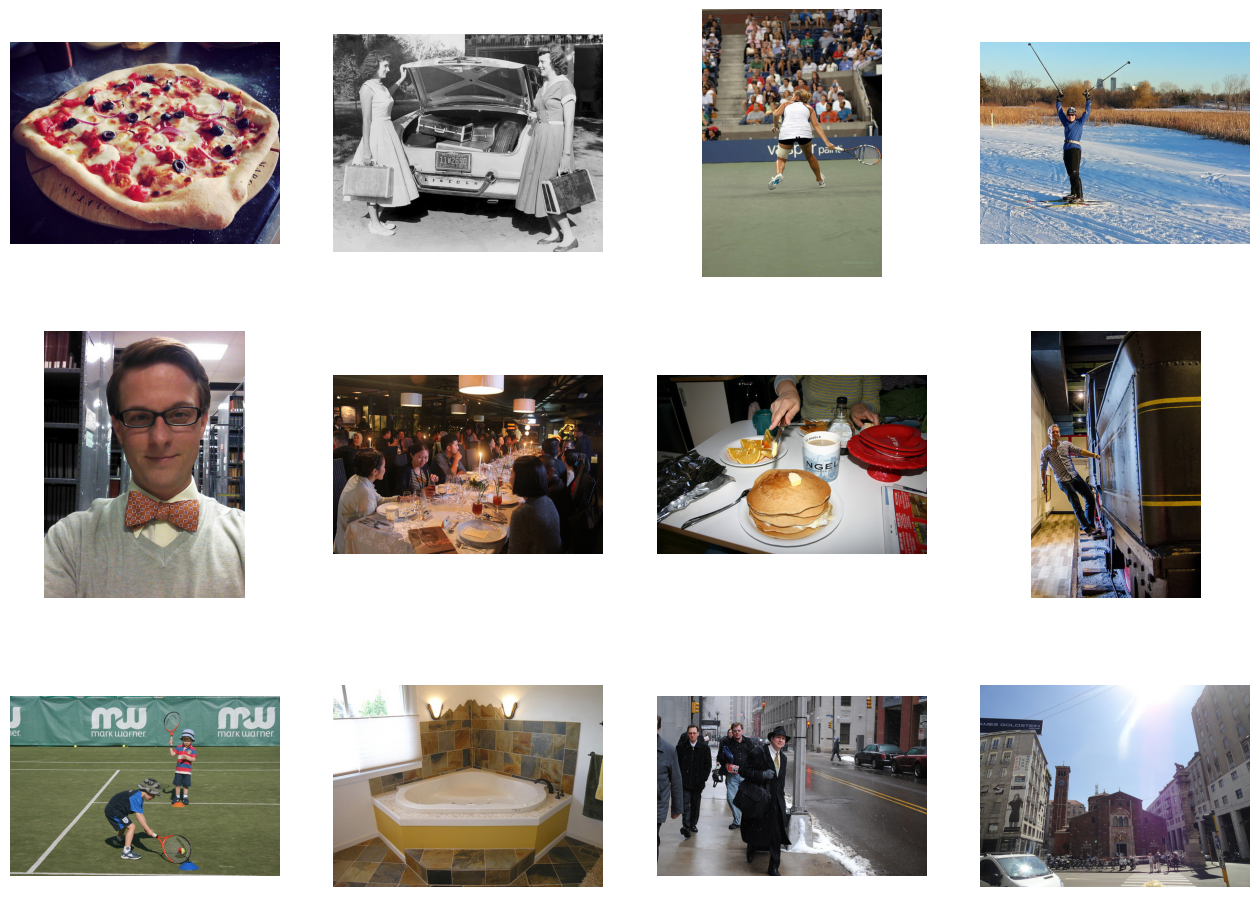

In [ ]:

from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

fig = plt.gcf()
fig.set_size_inches(16, 16)

score_sum = 0


next_pix = list(dataset.keys())
random.shuffle(next_pix)

# xception_model = Xception(include_top=False, pooling="avg")
# for i, image in enumerate(img_paths):
for i, image in enumerate(next_pix[0:12]):
  
  photo = extract_features(image,CNN_model)
  img = Image.open(image)
  description = generate_desc(loaded_model, tokenizer, photo, max_length)
  print("\n")
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  plt.imshow(img)

  print("predict:   ", description)
  print("answer:   ",dataset[image][0])
  reference = list(map(lambda x: x[7:-5].split(),dataset[image]))
  candidate = description[7:-5].lower().split()
  score = sentence_bleu(reference, candidate,smoothing_function=SmoothingFunction().method4)
  print("bleu score:" , score)

  score_sum +=score

average_score = score_sum/i



In [ ]:

from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

fig = plt.gcf()
fig.set_size_inches(16, 16)

score_sum = 0

next_pix = list(dataset.keys())
random.shuffle(next_pix)

# xception_model = Xception(include_top=False, pooling="avg")
# for i, image in enumerate(img_paths):



for i, image in enumerate(next_pix[0:32]):
  
  photo = extract_features(image,CNN_model)
  img = Image.open(image)
  #윤성(230418)
  # description = generate_desc(att_model, tokenizer, photo, max_length)
  description = generate_desc(load_model, tokenizer, photo, max_length)  
  print("predict:   ", description)
  print("answer:   ",dataset[image])
  reference = list(map(lambda x: x[7:-5].lower().split(),dataset[image]))
  candidate = description[7:-5].split()
  score = sentence_bleu(reference, candidate,smoothing_function=SmoothingFunction().method4)
  print("bleu score:" , score)

  score_sum +=score

average_score = score_sum/i
print("average_score",average_score)




resizing
1/1 [==============================] - 0s 30ms/step


AttributeError: ignored

<Figure size 1600x1600 with 0 Axes>

In [ ]:
tokenizer.word_index.get('end')
# tokenizer.word_index.get('start')
# tokenizer.word_index.get('toilet')


# tokenizer.word_index.get('<end>')


3

In [ ]:

# token_input = input()
# token_check= token_input
# print(token_check)

token_i=tokenizer.word_index.get("soccer")

print("input_index:", token_i)

input_index: 259


In [ ]:
  print(list(tokenizer.word_index.keys())[:200])


['<oov>', 'a', 'end', 'start', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'an', 'two', 'standing', 'at', 'people', 'are', 'next', 'white', 'woman', 'street', 'table', 'that', 'holding', 'large', 'person', 'some', 'it', 'down', 'top', 'group', 'up', 'field', 'small', 'near', 'black', 'tennis', 'his', 'front', 'train', 'riding', 'dog', 'plate', 'red', 'young', 'cat', 'room', 'by', 'water', 'baseball', 'sign', 'has', 'bathroom', 'playing', 'walking', 'while', 'blue', 'kitchen', 'bus', 'there', 'food', 'building', 'parked', 'pizza', 'side', 'grass', 'snow', 'green', 'bed', 'other', 'ball', 'looking', 'beach', 'three', 'for', 'boy', 'clock', 'couple', 'toilet', 'men', 'city', 'flying', 'her', 'road', 'skateboard', 'player', 'wearing', 'over', 'game', 'out', 'laying', 'sits', 'bench', 'from', 'girl', 'picture', 'wooden', 'bear', 'several', 'eating', 'brown', 'area', 'board', 'yellow', 'their', 'through', 'laptop', 'around', 'cake', 'horse', 'frisbee', 'one', 'sink'

Image size:  (539, 640, 3)
hog_image
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.63297266 2.30962858 ... 2.74978444 1.38974184 0.        ]
 [0.         2.30962858 1.63297266 ... 1.38974184 2.74978444 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


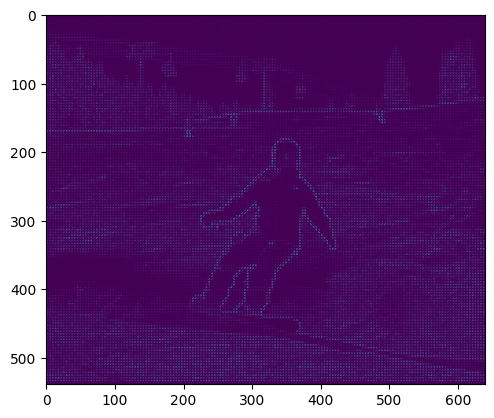

In [ ]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

# img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg"]
img_paths
im = cv2.imread(img_paths[2])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.14968284 0.09196376 ... 0.01405513 0.01617659 0.        ]
 [0.         0.09196376 0.14968284 ... 0.01617659 0.01405513 0.        ]
 ...
 [0.         0.12246587 0.33907852 ... 0.50978496 0.34381269 0.        ]
 [0.         0.33907852 0.12246587 ... 0.34381269 0.50978496 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


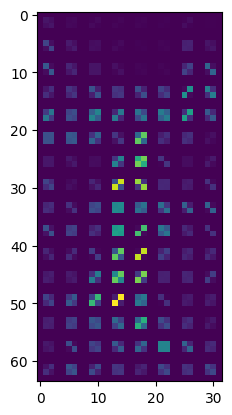

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#  윤성(230417 mobilenet용)
# im = cv2.resize (im, (24,24))
#  윤성(230417 vgg16용변경)
im = cv2.resize (im, (32,16))
#  윤성(230417 xception용변경)
# im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

# print ('hog_vec\n',hog_vec)

In [ ]:
our_CNN_feature = extract_features(img_paths[2], CNN_model)
scaler.fit(our_CNN_feature)
scaler.transform(our_CNN_feature)
print ('our_CNN_feature',our_CNN_feature)

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(our_CNN_feature, hog_vec)/(norm(our_CNN_feature)*norm(hog_vec))
print ("cos_sim",cos_sim)

1/1 [==============================] - 0s 28ms/step
our_CNN_feature [[0.03248177 0.         0.         ... 0.         0.         0.        ]]
cos_sim [0.14636438]


original size (555, 640, 3)


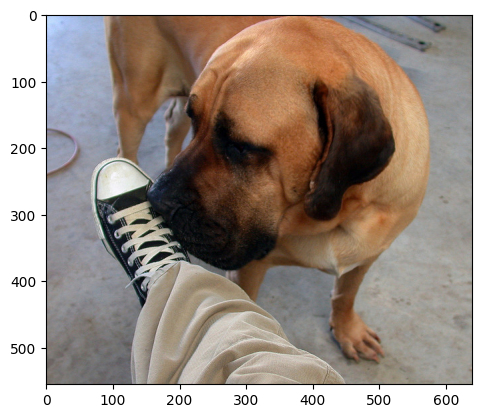

In [ ]:
im2_path = next_pix[0]

im2 = cv2.imread(im2_path)
print ('original size',im2.shape)
img2 = Image.open(im2_path)
plt.imshow(img2)

1/1 [==============================] - 0s 26ms/step
cos_sim2 [0.18438454]


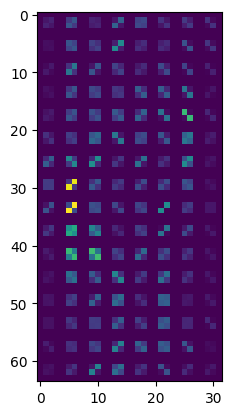

In [ ]:
# 윤성(230417)
# im2 =  cv2.resize(im2,(24,24))
im2 =  cv2.resize(im2,(32,16))
# im2 =  cv2.resize(im2,(32,64))
hog_image2 = hog_images(im2)
plt.imshow(hog_image2)

hog_image2 = np.array(hog_image2)
scaler.fit(hog_image2)
scaler.transform(hog_image2)
hog_vec2 = hog_image2.flatten()


our_CNN_feature = extract_features(im2_path, CNN_model)
scaler.fit(our_CNN_feature)
scaler.transform(our_CNN_feature)

cos_sim2 = dot(our_CNN_feature, hog_vec2)/(norm(our_CNN_feature)*norm(hog_vec2))
print ("cos_sim2",cos_sim2)

Image size:  (555, 640, 3)
hog_image
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.86995372 2.12343419 ... 1.94968158 0.1875     0.        ]
 [0.         2.12343419 1.86995372 ... 0.1875     1.94968158 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


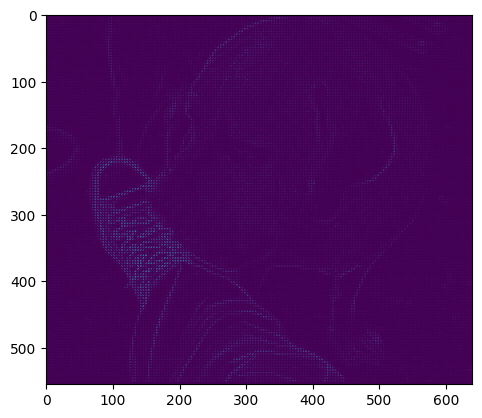

In [ ]:
# img_paths # 
im = cv2.imread(next_pix[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.20449652 0.31770072 ... 0.91706698 0.15345289 0.        ]
 [0.         0.31770072 0.20449652 ... 0.15345289 0.91706698 0.        ]
 ...
 [0.         0.11789108 0.15232038 ... 0.1746388  0.40583915 0.        ]
 [0.         0.15232038 0.11789108 ... 0.40583915 0.1746388  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
hog_vec
 [0. 0. 0. ... 0. 0. 0.]


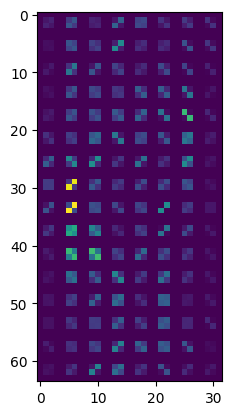

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)